# Pedestrian Segmentation with UNet


In this notebook, we will use UNet for pedestrian segmentation in **PyTorch**. The dataset we will use is the same as last tutorial: [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images and 345 instances of pedestrians with PASCAL annotation format. You should be familiar with seting and loading this dataset from the tutorial 3B.

**U-Net** is a convolutional network architecture for fast and precise segmentation of images. It was introduced in 2015 by [Olaf Ronneberger et al](https://arxiv.org/abs/1505.04597). and was originally designed for biomedical image segmentation. It consists of a contracting path (encoder) and an expansive path (decoder).
1. **Contracting path**: It follows the typical architecture of a convolutional network. It consists of the repeated unpadded convolutions, each followed by a ReLU and a 2x2 max pooling for downsampling.
2. **Bottleneck**: The deepest part of the network, where feature representations are at their most abstract.
3. **Expansive path**: this consists of multiple steps with upsampling of the feature map (transposed convolutions) to gradually restore spatial dimensions.
4. **Skip Connections**: Feature maps from corresponding encoder layers are concatenated with decoder layers to preserve spatial information, aiding precise segmentation.


<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="800" height="500">


First, the needed imports. If you are using Colab, it provides a pre-configured PyTorch environment, so we just need to import the relevant packages.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision
from torchvision.io import read_image
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os


print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.6.0+cu126
Using GPU, device name: NVIDIA GeForce RTX 4080 SUPER


## Dataset preparation


### 1. Download the Dataset
First, let’s download the Pedestrian dataset and extract the zip file:


In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

--2025-02-07 10:56:29--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  11.0MB/s    in 5.8s    

2025-02-07 10:56:36 (8.83 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPe

We have the following folder structure:

PennFudanPed/


*   PedMasks/



    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
*   PNGImages/


    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
    ...

### 2. Display an example of a pair of images and segmentation masks:

As shown in the following image and mask, each image has a corresponding segmentation mask, where each color correspond to a different instance.

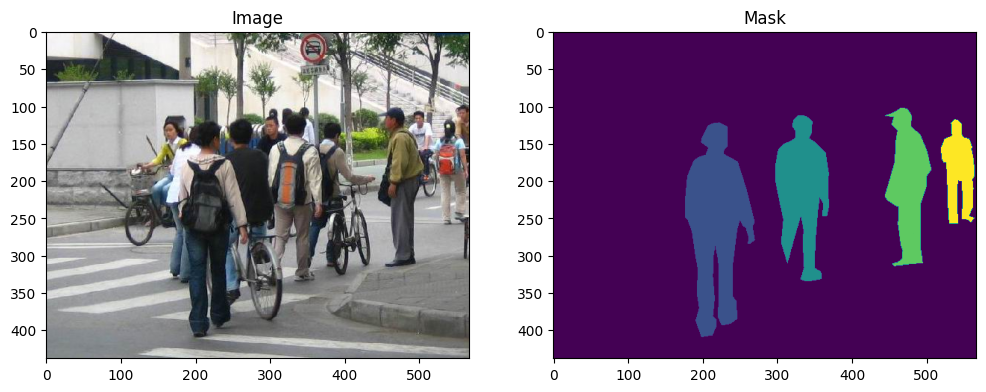

In [2]:
image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

### 3. Define the Dataset
Next, we need to write a class for this dataset. As the code below, we wrap images and masks into tensors. The dataset should inherit from the standard `torchvision.datasets` class, and implement **\_\_ len__** and **\_\_getitem__**.

the dataset **\_\_getitem__** should return a tuple:
*   **image**: shape [Batch_size, 3, H, W], a pure tensor, or a PIL Image of size (H, W)
*   **mask**: shape [Batch_size, 1, H, W], the segmentation masks for all pedestrians.

In [3]:

class PennFudanDataset(Dataset):
    def __init__(self, root, transform=None, target_size=(256, 256)):
        '''
        Initialize the dataset
        Args:
            root (str): Root directory of the dataset
            transforms: Transformations to be applied to images and targets
        '''
        self.root = root
        self.transform = transform
        self.target_size = target_size
        # Get sorted lists of image and mask filenames to ensure alignment
        self.imgs = sorted([f for f in os.listdir(os.path.join(root, "PNGImages")) if f.endswith(".png")])
        self.masks = sorted([f for f in os.listdir(os.path.join(root, "PedMasks")) if f.endswith(".png")])


    def __getitem__(self, idx):
        '''
        Get a single sample from the dataset
        Args: idx (int): Index of the sample to fetch
        Returns: tuple: (image, mask)
        '''
        # Construct full paths and load image and mask
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Make size consistent
        img = img.resize(self.target_size)
        mask = mask.resize(self.target_size, resample=Image.NEAREST)

        mask = np.array(mask, dtype=np.uint8)
        mask[mask > 0] = 1  # Create binary masks for each image

        if self.transform is not None:
          img = self.transform(img)
          mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

        return img, mask

    def __len__(self):
        return len(self.imgs)

### 4. Define the Transform and Dataloaders
Here, our transform only uses a basic conversion to a tensor. You are free to try with data augmentation.

In [4]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Initialize datasets for training and testing
dataset_all = PennFudanDataset('data/PennFudanPed', transform = trans)

# Split 80% for training and 10% for testing
train_size = int(0.8 * len(dataset_all))
test_size = len(dataset_all) - train_size
train_dataset, test_dataset = random_split(dataset_all, [train_size, test_size])

batch_size = 16

# Define DataLoader for training set and test set
# shuffle=True to randomize training samples, shuffle=False to maintain consistency in testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


The data loaders provide a way of iterating (making a loop over) the datasets, each time getting a new batch of data with the given batch size.

The first element of the image batch (`image`) is a 4th-order tensor of size (`batch_size`, 3, `image_size`, `image_size`), i.e. assuming `image_size` is 256, it consists of a batch of images of size 3x256x256 pixels, where the first value is the number of color channels.

The second element of the mask batch (`mask`) is a vector 4th-order tensor of size (`batch_size`, 1, `image_size`, `image_size`). It is the binary mask containing all pedestrains.

In [5]:
# Check the shape of image and mask
for (image, mask) in train_loader:
  print('image:', image.size(), 'type:', image.type())
  print('mask:', mask.size(), 'type:', mask.type())
  break


image: torch.Size([16, 3, 256, 256]) type: torch.FloatTensor
mask: torch.Size([16, 1, 256, 256]) type: torch.FloatTensor


## Building a classic U-Net model

### 1. Define network structure
As shown before, we can follow the classic architecture to manually build our own UNet. However, the result might not be "impressive" since this is the simplest UNet version. You are free to implement more advanced version, such as ResNet-UNet which has a pretrained ResNet as encoder.

In [ ]:
class DoubleConv(nn.Module):
    """two 3x3 convolution + ReLU"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder (down-sampling)
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder (up-sampling)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder and skip connection
        d4 = self.up4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final_conv(d1))  # The output is the possibility in [0,1]


model = UNet().to(device)


### 2. Define the Loss Function and Optimizer

In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3. Training the model
After the previous lab, you should be familiar with defining the training process.

First, a helper function to calculate the IoU.

In [8]:
def IoU(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()  # binarize prediction
    y_true = (y_true > threshold).float()

    intersection = (y_pred * y_true).sum(dim=(2, 3))  # compute intersection
    union = y_pred.sum(dim=(2, 3)) + y_true.sum(dim=(2, 3)) - intersection  # compute union

    iou = intersection / (union + 1e-6)
    return iou.mean()


In [9]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    total_loss = 0
    total_iou = 0

    for image, mask in data_loader:
        # Copy data and targets to GPU
        image = image.to(device)
        mask = mask.to(device)

        # Clear first
        optimizer.zero_grad()

        # Do a forward pass
        output = model(image)

        # Calculate the loss
        loss = criterion(output, mask)
        total_loss += loss
        total_iou += IoU(output, mask).item()

        # Backpropagation
        loss.backward()
        optimizer.step()


    train_loss = total_loss/len(data_loader)
    train_iou = total_iou/len(data_loader)

    print(f"Average loss: {train_loss:.4f}, IoU: {train_iou:.2f}")


In [11]:
epochs = 50
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)

Training epoch: 1
Average loss: 0.3593, IoU: 0.00
Training epoch: 2
Average loss: 0.3608, IoU: 0.05
Training epoch: 3
Average loss: 0.3598, IoU: 0.16
Training epoch: 4
Average loss: 0.3607, IoU: 0.24
Training epoch: 5
Average loss: 0.3584, IoU: 0.21
Training epoch: 6
Average loss: 0.3515, IoU: 0.24
Training epoch: 7
Average loss: 0.3501, IoU: 0.23
Training epoch: 8
Average loss: 0.3645, IoU: 0.28
Training epoch: 9
Average loss: 0.3548, IoU: 0.17
Training epoch: 10
Average loss: 0.3502, IoU: 0.22
Training epoch: 11
Average loss: 0.3436, IoU: 0.25
Training epoch: 12
Average loss: 0.3762, IoU: 0.27
Training epoch: 13
Average loss: 0.3608, IoU: 0.24
Training epoch: 14
Average loss: 0.3545, IoU: 0.22
Training epoch: 15
Average loss: 0.3375, IoU: 0.24
Training epoch: 16
Average loss: 0.3343, IoU: 0.31
Training epoch: 17
Average loss: 0.3260, IoU: 0.33
Training epoch: 18
Average loss: 0.3265, IoU: 0.32
Training epoch: 19
Average loss: 0.3267, IoU: 0.31
Training epoch: 20
Average loss: 0.3222,

## Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data.

The code is similar to the training code: we just loop over the whole testset, but no need to do backpropagation or calculate any gradients this time.

In [12]:
def test(test_loader, model, criterion):
    model.eval()

    test_loss = 0
    total_iou = 0

    with torch.no_grad():
        for data, mask in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            mask = mask.to(device)

            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, mask)
            test_loss += loss.item()

            # Count number of correct digits
            total_iou += IoU(output, mask)

    test_loss = test_loss/len(test_loader)
    test_iou = total_iou/len(test_loader)

    print(f"Testset IoU: {test_iou:.2f}%, average loss: {test_loss:>7f}")

test(test_loader, model, criterion)

Testset IoU: 0.42%, average loss: 0.256990
